# Predicting if a particular sentence in a document will be present in the corresponding summary.

In [1]:
import nltk
import spacy
import pandas as pd
import re
import os
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

word = re.compile(r"\w+")
# cosine_similarity = (vec1.vec2)/(||vec1||.||vec2||) 
def cosine_string_similarity(str1,str2): 
    vec1=Counter(word.findall(str1))
    vec2=Counter(word.findall(str2))
    intersection = (set(vec1.keys())&set(vec2.keys()))
    # Square of values of both the vectors
    vec1_value = np.sum([vec1[x]**2 for x in vec1.keys()])
    vec2_value = np.sum([vec2[x]**2 for x in vec2.keys()])
    # Final denominator
    b = np.sqrt(vec1_value)*np.sqrt(vec2_value)
    # Final Numerator
    a = np.sum([vec1[x]*vec2[x] for x in intersection])
    # In case denominator is 0
    if not b: return 0
    else: return a/b
def prepro(article):
    nlp = spacy.load('en')
    # Cleaning the text
    lines = [ f.lower() for f in article if f != '\n' ]
    lines = [ f.replace('\n','') for f in lines ]
    title = lines[0] #First line of news article is always the title in this data
    lines = lines[1:] #Rest of the lines are considered as the main article

    # Creating tokens
    tokens = [ nltk.tokenize.word_tokenize(f) for f in lines ]
    # Separating the sentences
    sentences=[] 
    for f in lines:
        for sentence in nltk.tokenize.sent_tokenize(f):
            sentences.append(sentence)
    # Compiling all the lines into one single string for use
    doc_string=""
    for line in lines : 
        doc_string += line + " "
    # Creating lemmas
    doc = nlp(doc_string)
    lemmas = [ token.lemma_ for token in doc]
    pos_noun = [ (token.lemma_ , token.pos_) for token in doc if token.pos_=='NOUN' and token.lemma_.isalpha()] # Noun Parts of speech tags
    pos_proper_noun = [ (token.lemma_ , token.pos_) for token in doc if token.pos_=='PROPN'] # Proper Noun Parts of speech tags
    return title, lines, tokens, lemmas, pos_noun, pos_proper_noun ,sentences
categories = ['business','entertainment','politics','sport','tech']
print("Following Categories of news are avaiable")
print(categories)
ct=input("Enter category ")
#Reading the data one category at a time
bbc_news_path="E:\\IN\\Level 2\\BBC News Summary\\News Articles\\"+ct
bbc_summary_path="E:\\IN\\Level 2\\BBC News Summary\\Summaries\\" 
os.chdir(bbc_news_path)
df=pd.DataFrame(columns=['Title','Sentence','Sentence Length','Similariy to Title','Sentence Position','Sentence Cohesion','Main Concept','Proper Noun Appearance'])
nlp =spacy.load('en')
t1=[]
ss=[]
f1=[]
f2=[]
f3=[]
f4=[]
f5=[]
f6=[]
nos=[]
fno=[]
listof_nos=[]
fn=0
ccc=0
for f in os.listdir():
    file=open(bbc_news_path+"\\"+f)
    f_data=file.readlines()

    # PREPROCESSING
    title, lines , tokens , lemmas, pos_n, pos_pn, sentences = prepro(f_data)
    # Features of the articles and their sentences
    no_of_lines = len(lines)
    no_of_sentences = len(sentences)
    listof_nos.append(no_of_sentences)
    # Feature #1 Length of sentences
    sentence_length = [ len(sentence.split(' ')) for sentence in sentences]
    normalized_length = sentence_length / np.amax(sentence_length)
    # Feature #2 Similarity to title
    similarity_to_title = [cosine_string_similarity(title,sentence) for sentence in sentences]
    # Feature #3 Sentence Position
    percentile_sentence_position = [ (i+1)/no_of_sentences for i,sentence in enumerate(sentences)]
    #pos_tag = [t[1] for t in pos] #Tags of each token
    words_per_line = [len(line) for line in lines]
    # Feature #4 Similarity between sentences
    sim_between_sentences =[]
    for x in sentences:
        cs=[]
        for y in sentences:
            cs.append(cosine_string_similarity(x,y))
        sim_between_sentences.append(np.sum(cs)) # raw value of the particular sentence's similarity with other sentences
    sim_between_sentences = sim_between_sentences / np.max(sim_between_sentences)
    # Feature #5 Main Concept Indicator
    main_concept=[]
    nouns=[t[0] for t in pos_n]
    noun_freq=[]
    for i in nouns: noun_freq.append((i,nouns.count(i)))
    noun_freq = list(dict.fromkeys(noun_freq))
    noun_freq.sort(key= lambda x:x[1], reverse=True)
    noun_freq = noun_freq[:5]
    noun_freq_5 = [str(t[0]) for t in noun_freq]
    for sentence in sentences:
        flag = 0
        for i in noun_freq_5:
            if i in sentence:
                flag = 1 
                break
            else: 
                flag = 0
        main_concept.append(flag)
    # Feature #6 Proper Noun Indicator
    prop_noun=[]
    for sentence in sentences:
        flag=0
        for token in nlp(sentence):
            if token.pos_ =="PROPN":
                flag = 1
                break
            else : flag = 0
        prop_noun.append(flag)
    fn+=1
    t1.extend([title]*no_of_sentences)
    nos.extend([no_of_sentences]*no_of_sentences)
    ss.extend(sentences)
    f1.extend(normalized_length)
    f2.extend(similarity_to_title)
    f3.extend(percentile_sentence_position)
    f4.extend(sim_between_sentences)
    f5.extend(main_concept)
    f6.extend(prop_noun)
    fno.extend([fn]*no_of_sentences)
    for sentence in sentences: ccc+=1
    #print(normalized_length,title,sentences)  
    #print('****************************')

df['Title']=pd.Series(t1)
df['No of Sentence']=pd.Series(nos)
df['Sentence']=pd.Series(ss)
df['Sentence Length']=pd.Series(f1)
df['Similariy to Title']=pd.Series(f2)
df['Sentence Position']=pd.Series(f3)
df['Sentence Cohesion']=pd.Series(f4)
df['Main Concept']=pd.Series(f5)
df['Proper Noun Appearance']=pd.Series(f6)
df['File No']=pd.Series(fno)
#print(listof_nos)
df

Following Categories of news are avaiable
['business', 'entertainment', 'politics', 'sport', 'tech']
Enter category business
[20, 15, 12, 19, 12, 9, 13, 14, 12, 9, 11, 14, 11, 22, 28, 11, 10, 8, 11, 32, 15, 15, 10, 14, 23, 13, 14, 9, 19, 16, 14, 15, 10, 13, 9, 12, 18, 9, 11, 11, 15, 12, 9, 15, 13, 14, 10, 12, 26, 15, 15, 21, 8, 10, 14, 12, 21, 11, 12, 8, 10, 15, 15, 14, 15, 14, 15, 17, 24, 8, 11, 14, 11, 11, 9, 13, 22, 11, 12, 11, 13, 9, 24, 11, 9, 8, 18, 11, 20, 18, 16, 16, 14, 10, 12, 7, 22, 10, 17, 16, 16, 12, 20, 15, 10, 13, 10, 9, 7, 14, 25, 14, 17, 18, 9, 11, 19, 11, 21, 12, 23, 18, 10, 7, 11, 19, 21, 16, 9, 20, 23, 9, 14, 12, 20, 26, 9, 15, 15, 22, 11, 15, 11, 8, 11, 46, 9, 11, 28, 16, 13, 17, 16, 16, 13, 12, 12, 7, 34, 16, 17, 15, 17, 19, 17, 12, 12, 11, 9, 8, 11, 16, 16, 12, 10, 10, 16, 12, 10, 14, 22, 12, 36, 15, 12, 12, 15, 19, 18, 19, 20, 16, 14, 10, 18, 14, 13, 13, 18, 30, 15, 16, 14, 23, 13, 14, 14, 14, 26, 18, 12, 13, 19, 11, 23, 16, 23, 10, 13, 13, 17, 24, 13, 25, 11, 1

,Title,Sentence,Sentence Length,Similariy to Title,Sentence Position,Sentence Cohesion,Main Concept,Proper Noun Appearance,No of Sentence,File No
0,ad sales boost time warner profit,quarterly profits at us media giant timewarner...,0.567568,0.000000,0.050000,0.801570,1,0,20,1
1,ad sales boost time warner profit,"the firm, which is now one of the biggest inve...",0.621622,0.149071,0.100000,0.874912,1,1,20,1
2,ad sales boost time warner profit,timewarner said fourth quarter sales rose 2% t...,0.297297,0.113228,0.150000,0.618042,1,0,20,1
3,ad sales boost time warner profit,its profits were buoyed by one-off gains which...,0.540541,0.178174,0.200000,0.696100,1,0,20,1
4,ad sales boost time warner profit,time warner said on friday that it now owns 8%...,0.351351,0.218218,0.250000,0.589618,1,1,20,1
5,ad sales boost time warner profit,"but its own internet business, aol, had has mi...",0.270270,0.000000,0.300000,0.424783,1,0,20,1
6,ad sales boost time warner profit,"it lost 464,000 subscribers in the fourth quar...",0.459459,0.000000,0.350000,0.766130,1,0,20,1
7,ad sales boost time warner profit,"however, the company said aol's underlying pro...",0.540541,0.085126,0.400000,0.796353,1,0,20,1
8,ad sales boost time warner profit,it hopes to increase subscribers by offering t...,0.729730,0.000000,0.450000,0.966150,1,0,20,1
9,ad sales boost time warner profit,timewarner also has to restate 2000 and 2003 r...,0.648649,0.000000,0.500000,0.922843,1,1,20,1


### Features

I have considered the following 6 features- 

1. Normalised Sentence Length- This feature is the length of each sentence. Each length value is normalised to a scale ∈ [0,1] by dividing each value with the maximum sentence length of the document.

2. Similarity to Title - Each sentence's similarity is compared to the title of the document. In this dataset of BBC, the first line of the news article is always the Title of the document. So, for each sentence in the document, its similarity with the title is calculated. The similarity measure used here is cosine similarity.

*cosine similarity of two vectors a & b = (a.b)/(||a||.||b||), where '.' represents dot product*

3. Sentence Position - Each sentence's position in the document is taken into account. This value is normalized by dividing each value with the total number of sentences in the document. 

4. Similarity between sentences - Each sentence's cosine similarity is taken with each sentence in the document. This way we will get multiple cosine similarity values for each sentence corresponding to its similarity with each sentence. All these values are added up to create a raw value. All raw values are then normalized by dividing each of them with the highest raw value in the document. This feature can also be called **Sentence Cohesion**.

5. Main Concept Indicator- If a particular noun occurs considerable times in a sentence then we can consider it a main concept, meaning, it must have some value in predicting the sentence's occurence in the summary. So, we calculate the number of nouns in the document along with each of their frequency. The noun with the highest frequencies (5) are then considered main concepts. The sentence which contain these values will be then tagged *True* for occurence in summary. Rest will be *false*.

6. Proper Noun Indicator- If the sentence has use of Proper Nouns in it, then it must have important tokens present in it, hence, its occurence in the summary.

In [3]:
bbc_summary_path="E:\\IN\\Level 2\\BBC News Summary\\Summaries\\"+ct 
os.chdir(bbc_summary_path)
file_names=os.listdir()
summ=[]
art=[]
for nos,n in zip(listof_nos,file_names):
    file=open(bbc_summary_path+"\\"+n)
    article=file.readline()
    article=article.replace('Â','').lower()
    art.extend([article]*nos)
  
df['Article Summary']=pd.Series(art)
in_summary=[int(s in arts) for arts,s in zip(df['Article Summary'],df['Sentence'])]
df['In Summary']=pd.Series(in_summary)
df

,Title,Sentence,Sentence Length,Similariy to Title,Sentence Position,Sentence Cohesion,Main Concept,Proper Noun Appearance,No of Sentence,File No,Article Summary,In Summary
0,ad sales boost time warner profit,quarterly profits at us media giant timewarner...,0.567568,0.000000,0.050000,0.801570,1,0,20,1,timewarner said fourth quarter sales rose 2% t...,0
1,ad sales boost time warner profit,"the firm, which is now one of the biggest inve...",0.621622,0.149071,0.100000,0.874912,1,1,20,1,timewarner said fourth quarter sales rose 2% t...,0
2,ad sales boost time warner profit,timewarner said fourth quarter sales rose 2% t...,0.297297,0.113228,0.150000,0.618042,1,0,20,1,timewarner said fourth quarter sales rose 2% t...,1
3,ad sales boost time warner profit,its profits were buoyed by one-off gains which...,0.540541,0.178174,0.200000,0.696100,1,0,20,1,timewarner said fourth quarter sales rose 2% t...,1
4,ad sales boost time warner profit,time warner said on friday that it now owns 8%...,0.351351,0.218218,0.250000,0.589618,1,1,20,1,timewarner said fourth quarter sales rose 2% t...,0
5,ad sales boost time warner profit,"but its own internet business, aol, had has mi...",0.270270,0.000000,0.300000,0.424783,1,0,20,1,timewarner said fourth quarter sales rose 2% t...,0
6,ad sales boost time warner profit,"it lost 464,000 subscribers in the fourth quar...",0.459459,0.000000,0.350000,0.766130,1,0,20,1,timewarner said fourth quarter sales rose 2% t...,1
7,ad sales boost time warner profit,"however, the company said aol's underlying pro...",0.540541,0.085126,0.400000,0.796353,1,0,20,1,timewarner said fourth quarter sales rose 2% t...,1
8,ad sales boost time warner profit,it hopes to increase subscribers by offering t...,0.729730,0.000000,0.450000,0.966150,1,0,20,1,timewarner said fourth quarter sales rose 2% t...,0
9,ad sales boost time warner profit,timewarner also has to restate 2000 and 2003 r...,0.648649,0.000000,0.500000,0.922843,1,1,20,1,timewarner said fourth quarter sales rose 2% t...,0


Now we have added the labels with which we can perform train, test split of the data for supervised learning algorithms.

In [4]:
final_df = df[['Title','File No','Sentence','Sentence Length','Similariy to Title','Sentence Position','Sentence Cohesion',
               'Main Concept','Proper Noun Appearance','In Summary']]
final_df.to_csv("E:\\IN\\Level 2\\BBC News Summary\\business_features.csv")
final_df

,Title,File No,Sentence,Sentence Length,Similariy to Title,Sentence Position,Sentence Cohesion,Main Concept,Proper Noun Appearance,In Summary
0,ad sales boost time warner profit,1,quarterly profits at us media giant timewarner...,0.567568,0.000000,0.050000,0.801570,1,0,0
1,ad sales boost time warner profit,1,"the firm, which is now one of the biggest inve...",0.621622,0.149071,0.100000,0.874912,1,1,0
2,ad sales boost time warner profit,1,timewarner said fourth quarter sales rose 2% t...,0.297297,0.113228,0.150000,0.618042,1,0,1
3,ad sales boost time warner profit,1,its profits were buoyed by one-off gains which...,0.540541,0.178174,0.200000,0.696100,1,0,1
4,ad sales boost time warner profit,1,time warner said on friday that it now owns 8%...,0.351351,0.218218,0.250000,0.589618,1,1,0
5,ad sales boost time warner profit,1,"but its own internet business, aol, had has mi...",0.270270,0.000000,0.300000,0.424783,1,0,0
6,ad sales boost time warner profit,1,"it lost 464,000 subscribers in the fourth quar...",0.459459,0.000000,0.350000,0.766130,1,0,1
7,ad sales boost time warner profit,1,"however, the company said aol's underlying pro...",0.540541,0.085126,0.400000,0.796353,1,0,1
8,ad sales boost time warner profit,1,it hopes to increase subscribers by offering t...,0.729730,0.000000,0.450000,0.966150,1,0,0
9,ad sales boost time warner profit,1,timewarner also has to restate 2000 and 2003 r...,0.648649,0.000000,0.500000,0.922843,1,1,0


In [5]:
final_df.describe()

,File No,Sentence Length,Similariy to Title,Sentence Position,Sentence Cohesion,Main Concept,Proper Noun Appearance,In Summary
count,7756.000000,7756.000000,7756.000000,7756.000000,7756.000000,7756.000000,7756.000000,7756.000000
mean,256.249484,0.571567,0.091755,0.532878,0.745315,0.818334,0.096699,0.387571
std,143.056398,0.223518,0.101077,0.288263,0.174409,0.385594,0.295567,0.487227
min,1.000000,0.025000,0.000000,0.020833,0.000000,0.000000,0.000000,0.000000
25%,137.750000,0.400000,0.000000,0.285714,0.634026,1.000000,0.000000,0.000000
50%,257.000000,0.551724,0.079057,0.533333,0.764638,1.000000,0.000000,0.000000
75%,376.000000,0.727273,0.146647,0.785714,0.877780,1.000000,0.000000,1.000000
max,510.000000,1.000000,0.639010,1.000000,1.000000,1.000000,1.000000,1.000000


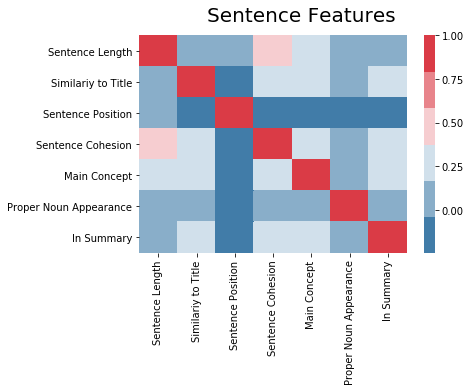

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
fig=plt.figure()
fig.suptitle('Sentence Features',fontsize=20)
ax = sns.heatmap(final_df[['Sentence Length','Similariy to Title','Sentence Position','Sentence Cohesion',
               'Main Concept','Proper Noun Appearance','In Summary']].corr(), cmap=sns.diverging_palette(240, 10))
plt.show()

Corelation is very cold between the features.

#### Train, Test splitting -

In [6]:
from sklearn.model_selection import train_test_split
X=final_df[['Sentence Length','Similariy to Title','Sentence Position','Sentence Cohesion',
               'Main Concept','Proper Noun Appearance']]
y=final_df['In Summary']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)

SVC gives very less training and testing score

In [10]:
from sklearn.svm import SVC
import time
st=time.time()
svcc=SVC(kernel='linear')
svcc.fit(X_train,y_train)
print('SVC TEST SCORE')
print(svcc.score(X_test,y_test))
print('------------------')
print('SVC TRAINING SCORE')
print(svcc.score(X_train,y_train))
print("--- %s seconds ---" % (time.time() - st))

SVC TEST SCORE
0.667354306343476
------------------
SVC TRAINING SCORE
0.6902183255973869
--- 0.9913091659545898 seconds ---


Train score high, but model is underfitting in Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier
#model with 1000 decision trees
st=time.time()
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf.fit(X_train, y_train)
print('Random Forest TEST SCORE')
print(rf.score(X_test,y_test))
print('------------------')
print('Random Forest TRAINING SCORE')
print(rf.score(X_train,y_train))
print("--- %s seconds ---" % (time.time() - st))

Random Forest TEST SCORE
0.6621970087674058
------------------
Random Forest TRAINING SCORE
0.9993123603231906
--- 9.879287242889404 seconds ---


In [12]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix (y,rf.predict(X)))

,0,1
0,4464,286
1,373,2633


In [59]:
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB() 
gnb.fit(X_train, y_train)
print('Naive Bayes TEST SCORE')
print(gnb.score(X_test,y_test))
print('------------------')
print('Naive Bayes TRAINING SCORE')
print(gnb.score(X_train,y_train))
print("--- %s seconds ---" % (time.time() - st))

Naive Bayes TEST SCORE
0.6379577101598762
------------------
Naive Bayes TRAINING SCORE
0.6386453498366855
--- 148.73713397979736 seconds ---


In [34]:
def predicIfInSummary(s,x,sent):
    x=X.where(final_df['File No']==s).dropna()
    y=x.where( final_df['Sentence']==sent).dropna()
    print(sent)
    print()
    if rf.predict(y) == 1: print('is in summary')
    else : print('is not in summary')
    print()
    print("of the document titled'"+final_df['Title'].where(final_df['Sentence']==sent).dropna()+"'")
    print()
    print("Sentence Details - ")
    print(y.dropna())
filename=int(input("Enter File no "))
sentence = input("Enter Sentence ")
print()
predicIfInSummary(filename,ct,sentence)
# timewarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn.

Enter File no 1
Enter Sentence timewarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn.

timewarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn.

is in summary

2    of the document titled'ad sales boost time war...
Name: Title, dtype: object

Sentence Details - 
   Sentence Length  Similariy to Title  Sentence Position  Sentence Cohesion  \
2         0.297297            0.113228               0.15           0.618042   

   Main Concept  Proper Noun Appearance  
2           1.0                     0.0  
